In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import pickle
import json
import torch
from tqdm import tqdm, tqdm_notebook
from itertools import combinations

from pycit import *
from bullseye import *
from performance import *

from sdcit.utils import rbf_kernel_median, K2D
from sdcit.hsic import HSIC, c_HSIC
from sdcit.kcipt import c_KCIPT
from sdcit.sdcit_mod import c_SDCIT
from CCIT import CCIT

# matplotlib and seaborn settings
from matplotlib import rc
rc('text', usetex=True)
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

sns.set_style("white")

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 14}

# plt.legend(prop={'family':'serif', 'size': 12}, loc=4)

In [9]:
ci_dict = get_ci_dict()

# bullseye settings
num_samples = 5000
dim = 3

# knn settings
statistic_args = {
    'k': 5
}
test_args={
    'k_perm': 10,
    'n_trials': 250,
    'knn_jobs': 11,
    'n_jobs': 11
}

# ccit settings
num_iter=30
max_depths = [12, 20, 26]
n_estimators = [100, 200, 300]
bootstrap=True
nthread=11

# kernel settings
kernel_sample_size = 5000
size_of_null_sample = 250
n_jobs = 11

# perform cits
pred_sdcit, true_sdcit = [], []
pred_knn, true_knn = [], []
pred_ccit, true_ccit = [], []
for i in range(6):
    for size in range(1,5):
        for cond_set in combinations([k for k in range(6) if k != i], size):
            # generate data
            r_data, x_data, y_data = bullseye_network(num_samples, dim, eps=0.075)
            r_data = standardize(r_data.astype(np.float16))
            x_data = standardize(x_data.astype(np.float16))
            y_data = standardize(y_data.astype(np.float16))

            # true ci relation
            ground_truth = 0
            if i in ci_dict:
                if set(cond_set) in ci_dict[i]:
                    ground_truth = 1

            print("is CI: %r, var: %d, cond_set: %s"%(bool(ground_truth), i, str(cond_set)))

            # kernel method
            Kx, Ky, Kz = rbf_kernel_median(x_data[:kernel_sample_size,:,i], \
                                        y_data[:kernel_sample_size], \
                                        x_data[:kernel_sample_size,:,cond_set].reshape((kernel_sample_size,-1)))
            pval_sdcit = c_SDCIT(Kx, Ky, Kz, Dz=K2D(Kz), size_of_null_sample=size_of_null_sample, n_jobs=n_jobs)[1]
            pred_sdcit.append(pval_sdcit)
            true_sdcit.append(ground_truth)
            print ("  sdcit pval: %0.3f"%pval_sdcit)
            del Kx, Ky, Kz

            # knn method
            pval_knn = citest(x_data[:,:,i], y_data, x_data[:,:,cond_set], statistic='ksg_cmi', statistic_args=statistic_args, test_args=test_args)
            pred_knn.append(pval_knn)
            true_knn.append(ground_truth)
            print ("  knn pval: %0.3f"%pval_knn)

            # ccit
            pval_ccit = CCIT.CCIT(x_data[:,:,i], y_data, x_data[:,:,cond_set].reshape((num_samples,-1)), \
                                    max_depths=max_depths, n_estimators=n_estimators, num_iter=num_iter, bootstrap=bootstrap, nthread=nthread)
            pred_ccit.append(pval_ccit)
            true_ccit.append(ground_truth)
            print ("  ccit pval: %0.3f"%pval_ccit)

performance_sdcit = np.stack((pred_sdcit, true_sdcit))
performance_knn = np.stack((pred_knn, true_knn))
performance_ccit = np.stack((pred_ccit, true_ccit))

np.save("data/bullseye_3d_performance_sdcit.npy", performance_sdcit)
np.save("data/bullseye_3d_performance_knn.npy", performance_knn)
np.save("data/bullseye_3d_performance_ccit.npy", performance_ccit)

is CI: False, var: 0, cond_set: (1,)
  knn pval: 0.000
is CI: False, var: 0, cond_set: (2,)
  knn pval: 0.896
is CI: False, var: 0, cond_set: (3,)
  knn pval: 0.000
is CI: False, var: 0, cond_set: (4,)
  knn pval: 0.000
is CI: False, var: 0, cond_set: (5,)
  knn pval: 0.000
is CI: True, var: 0, cond_set: (1, 2)
  knn pval: 0.008
is CI: False, var: 0, cond_set: (1, 3)
  knn pval: 0.000
is CI: False, var: 0, cond_set: (1, 4)
  knn pval: 0.000
is CI: False, var: 0, cond_set: (1, 5)
  knn pval: 0.000
is CI: False, var: 0, cond_set: (2, 3)
  knn pval: 0.000
is CI: True, var: 0, cond_set: (2, 4)
  knn pval: 0.000
is CI: False, var: 0, cond_set: (2, 5)
  knn pval: 0.000
is CI: False, var: 0, cond_set: (3, 4)
  knn pval: 0.000
is CI: False, var: 0, cond_set: (3, 5)
  knn pval: 0.000
is CI: False, var: 0, cond_set: (4, 5)
  knn pval: 0.000
is CI: True, var: 0, cond_set: (1, 2, 3)
  knn pval: 0.020
is CI: True, var: 0, cond_set: (1, 2, 4)
  knn pval: 0.180
is CI: True, var: 0, cond_set: (1, 2, 5

AUC knn: 0.6827789327789462
AUC ccit: 0.8059790559790575
AUC sdcit: 0.865211365211367


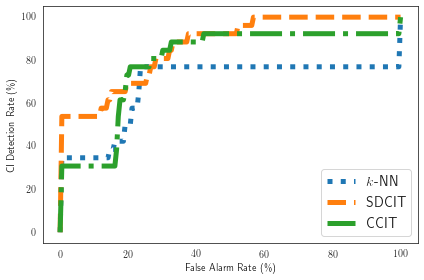

In [11]:
performance_sdcit = np.load("data/bullseye_3d_performance_sdcit.npy")
performance_knn = np.load("data/bullseye_3d_performance_knn.npy")
performance_ccit = np.load("data/bullseye_3d_performance_ccit.npy")

eps = 1e-4
fars = np.linspace(0., 100., 200)/100
drs_knn = np.zeros(fars.shape)
drs_ccit = np.zeros(fars.shape)
drs_sdcit = np.zeros(fars.shape)
for i,far in enumerate(fars):
    drs_knn[i] = detection_atper(np.clip(performance_knn[0], eps, 1-eps), performance_knn[1], target_far=far)
    drs_ccit[i] = detection_atper(np.clip(performance_ccit[0], eps, 1-eps), performance_ccit[1], target_far=far)
    drs_sdcit[i] = detection_atper(np.clip(performance_sdcit[0], eps, 1-eps), performance_sdcit[1], target_far=far)

print ("AUC knn:", area_under_roc(performance_knn[0], performance_knn[1]))
print ("AUC ccit:", area_under_roc(performance_ccit[0], performance_ccit[1]))
print ("AUC sdcit:", area_under_roc(performance_sdcit[0], performance_sdcit[1]))

plt.figure(figsize=(6,4))
plt.plot(fars*100, drs_knn*100, ':', lw=5, label="$k$-NN")
plt.plot(fars*100, drs_sdcit*100, '--', lw=5, label="SDCIT")
plt.plot(fars*100, drs_ccit*100, '-.', lw=5, label="CCIT")
plt.ylabel("CI Detection Rate (\%)")
plt.xlabel("False Alarm Rate (\%)")
plt.legend(prop={'family':'serif', 'size': 14}, loc=4)
plt.tight_layout()
plt.show()